# aDDM Inference Comparison: Cython vs JAX

This notebook compares Maximum Likelihood Estimation (MLE) for the attention-dependent Drift Diffusion Model using:

1. **Cython + OpenMP** (gradient-free optimization)
2. **JAX** (gradient-free optimization)
3. **JAX + Autodiff** (gradient-based optimization)

We use ~1000 simulated trials for reasonable runtime.


## 1. Setup and Data Simulation


In [1]:
# Add src to path if running from examples directory
import sys
from pathlib import Path
src_path = Path("../src").resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize, Bounds

# JAX imports
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

print(f"JAX version: {jax.__version__}")
print(f"Available devices: {jax.devices()}")


JAX version: 0.8.2
Available devices: [CpuDevice(id=0)]


In [2]:
# ============================================================
# CONFIGURATION
# ============================================================
NUM_TRIALS = 1000      # Number of trials to simulate
RANDOM_SEED = 42       # For reproducibility

# True parameters for data generation
TRUE_PARAMS = {
    'eta': 0.7,        # Attention discount factor (0-1)
    'kappa': 0.5,      # Drift scaling
    'a': 2.1,          # Initial boundary
    'b': 0.3,          # Boundary collapse rate
    'x0': -0.2,        # Starting position
    'sigma': 1.0,      # Diffusion coefficient (fixed)
}

# Fixation time distribution parameters (Gamma)
FIXATION_SHAPE = 6
FIXATION_SCALE = 0.1

print(f"Simulating {NUM_TRIALS} trials with:")
for k, v in TRUE_PARAMS.items():
    print(f"  {k} = {v}")


Simulating 1000 trials with:
  eta = 0.7
  kappa = 0.5
  a = 2.1
  b = 0.3
  x0 = -0.2
  sigma = 1.0


In [3]:
# Import simulator
from efficient_fpt.models import DDModel, piecewise_const_func
from efficient_fpt.utils import get_alternating_mu_array

class aDDModel(DDModel):
    """Attentional Drift Diffusion Model for a single trial."""
    def __init__(self, mu1, mu2, sacc_array, flag, sigma, a, b, x0):
        super().__init__(x0)
        self.mu1 = mu1
        self.mu2 = mu2
        self.sacc_array = sacc_array
        self.flag = flag  # 0: start with mu1, 1: start with mu2
        self.d = len(sacc_array)
        self.mu_array = get_alternating_mu_array(mu1, mu2, self.d, flag)
        self.sigma = sigma
        self.a = a
        self.b = b

    def drift_coeff(self, X, t):
        return piecewise_const_func(t, self.mu_array, self.sacc_array)

    def diffusion_coeff(self, X, t):
        return self.sigma

    @property
    def is_update_vectorizable(self):
        return True

    def upper_bdy(self, t):
        return self.a - self.b * t

    def lower_bdy(self, t):
        return -self.a + self.b * t


In [4]:
def simulate_trial(rng, eta, kappa, sigma, a, b, x0, T_max, shape, scale):
    """Simulate a single aDDM trial."""
    # Generate fixation times
    fixations = rng.gamma(shape, scale, 100)
    sacc_array = np.insert(np.cumsum(fixations), 0, 0)
    sacc_array = sacc_array[sacc_array < T_max]
    
    # Random initial attention and stimulus values
    flag = rng.integers(0, 2)
    r1 = rng.integers(1, 6)
    r2 = rng.integers(1, 6)
    
    # Compute drift rates
    mu1 = kappa * (r1 - eta * r2)
    mu2 = kappa * (eta * r1 - r2)
    
    # Simulate
    model = aDDModel(mu1, mu2, sacc_array, flag, sigma, a, b, x0)
    rt, choice = model.simulate_fpt_datum(dt=1e-4)
    
    # Truncate saccade array to actual RT
    sacc_array = sacc_array[sacc_array < rt]
    d = len(sacc_array)
    mu_array = get_alternating_mu_array(mu1, mu2, d, flag)
    
    return {
        'rt': rt,
        'choice': int(choice),
        'mu_array': mu_array,
        'sacc_array': sacc_array,
        'd': d,
        'r1': r1,
        'r2': r2,
        'flag': flag,
        'mu1': mu1,
        'mu2': mu2,
    }

# Simulate data
print(f"Simulating {NUM_TRIALS} trials...")
rng = np.random.default_rng(RANDOM_SEED)
T_max = TRUE_PARAMS['a'] / TRUE_PARAMS['b']

start = time.time()
trials = []
for i in range(NUM_TRIALS):
    if (i + 1) % 200 == 0:
        print(f"  {i+1}/{NUM_TRIALS}...")
    trial = simulate_trial(
        rng, TRUE_PARAMS['eta'], TRUE_PARAMS['kappa'], 
        TRUE_PARAMS['sigma'], TRUE_PARAMS['a'], TRUE_PARAMS['b'], 
        TRUE_PARAMS['x0'], T_max, FIXATION_SHAPE, FIXATION_SCALE
    )
    trials.append(trial)

print(f"Simulation completed in {time.time() - start:.1f}s")


Simulating 1000 trials...
  200/1000...
  400/1000...
  600/1000...
  800/1000...
  1000/1000...
Simulation completed in 297.2s


In [5]:
# Prepare data arrays
rt_data = np.array([t['rt'] for t in trials], dtype=np.float64)
choice_data = np.array([t['choice'] for t in trials], dtype=np.int32)
d_data = np.array([t['d'] for t in trials], dtype=np.int32)
r1_data = np.array([t['r1'] for t in trials], dtype=np.float64)
r2_data = np.array([t['r2'] for t in trials], dtype=np.float64)
flag_data = np.array([t['flag'] for t in trials], dtype=np.int32)
mu1_data = np.array([t['mu1'] for t in trials], dtype=np.float64)
mu2_data = np.array([t['mu2'] for t in trials], dtype=np.float64)

# Pad arrays to max length
max_d = max(d_data)
mu_data_padded = np.zeros((NUM_TRIALS, max_d), dtype=np.float64)
sacc_data_padded = np.zeros((NUM_TRIALS, max_d), dtype=np.float64)

for i, t in enumerate(trials):
    d = t['d']
    mu_data_padded[i, :d] = t['mu_array']
    sacc_data_padded[i, :d] = t['sacc_array']

print(f"Data summary:")
print(f"  Trials: {NUM_TRIALS}")
print(f"  Max stages: {max_d}")
print(f"  Mean stages: {np.mean(d_data):.1f}")
print(f"  RT range: [{rt_data.min():.2f}, {rt_data.max():.2f}]")
print(f"  Upper choices: {np.sum(choice_data == 1)} ({100*np.mean(choice_data == 1):.1f}%)")


Data summary:
  Trials: 1000
  Max stages: 11
  Mean stages: 3.5
  RT range: [0.27, 5.45]
  Upper choices: 492 (49.2%)


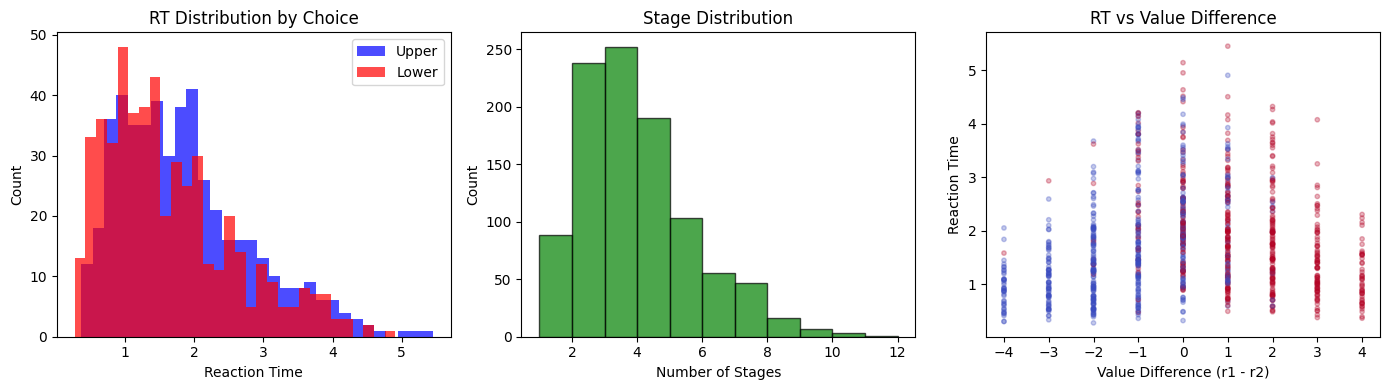

In [6]:
# Visualize data
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].hist(rt_data[choice_data == 1], bins=30, alpha=0.7, label='Upper', color='blue')
axes[0].hist(rt_data[choice_data == -1], bins=30, alpha=0.7, label='Lower', color='red')
axes[0].set_xlabel('Reaction Time')
axes[0].set_ylabel('Count')
axes[0].set_title('RT Distribution by Choice')
axes[0].legend()

axes[1].hist(d_data, bins=range(1, max_d + 2), alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('Number of Stages')
axes[1].set_ylabel('Count')
axes[1].set_title('Stage Distribution')

axes[2].scatter(r1_data - r2_data, rt_data, alpha=0.3, s=10, c=choice_data, cmap='coolwarm')
axes[2].set_xlabel('Value Difference (r1 - r2)')
axes[2].set_ylabel('Reaction Time')
axes[2].set_title('RT vs Value Difference')

plt.tight_layout()
plt.show()


## 2. Define Likelihood Functions


In [7]:
# ============================================================
# CONFIGURATION: Which implementations to test
# ============================================================
RUN_CYTHON = True     # Cython + OpenMP (if available)
RUN_JAX_NOGRAD = True # JAX without gradients
RUN_JAX_GRAD = True   # JAX with gradients

TRUNC_NUM = 6         # Series terms (6 is optimal for JAX due to XLA threshold)


In [8]:
# Try to import Cython implementation
CYTHON_AVAILABLE = False
if RUN_CYTHON:
    try:
        from efficient_fpt.multi_stage_cy import compute_loss_parallel, print_num_threads
        CYTHON_AVAILABLE = True
        print("Cython implementation available:")
        print_num_threads()
    except ImportError as e:
        print(f"Cython not available: {e}")
        print("(Run 'pip install -e .' to build Cython extensions)")


Cython implementation available:
Number of available threads: 12


In [9]:
# JAX implementation - using FAST version with optimized gradients
from efficient_fpt_jax.multi_stage import get_addm_fptd_jax_fast, pad_sacc_array_safely

# Pre-convert to JAX arrays
jax_rt = jnp.array(rt_data)
jax_choice = jnp.array(choice_data)
jax_d = jnp.array(d_data)
jax_r1 = jnp.array(r1_data)
jax_r2 = jnp.array(r2_data)
jax_flag = jnp.array(flag_data)
jax_sacc = jnp.array(sacc_data_padded)

# PRE-COMPUTE safe saccade arrays (Option 1 optimization)
# This avoids re-computing safe padding on every likelihood evaluation
print("Pre-computing safe saccade arrays...")
jax_sacc_safe = vmap(lambda s, d: pad_sacc_array_safely(s, d, max_d))(jax_sacc, jax_d)

print(f"JAX arrays created (trunc_num={TRUNC_NUM})")
print(f"Using get_addm_fptd_jax_fast with pre-computed safe saccade arrays")


Pre-computing safe saccade arrays...
JAX arrays created (trunc_num=6)
Using get_addm_fptd_jax_fast with pre-computed safe saccade arrays


In [10]:
def compute_mu_arrays(eta, kappa, r1, r2, flag, sacc, d, max_d):
    """Compute mu arrays for all trials given parameters."""
    mu1 = kappa * (r1 - eta * r2)
    mu2 = kappa * (eta * r1 - r2)
    
    # Build mu arrays: alternate between mu1 and mu2 based on flag
    # For flag=0: [mu1, mu2, mu1, ...]
    # For flag=1: [mu2, mu1, mu2, ...]
    stage_idx = jnp.arange(max_d)
    # mu_val[i,j] = mu1[i] if (flag[i] + j) is even, else mu2[i]
    is_mu1 = (flag[:, None] + stage_idx[None, :]) % 2 == 0
    mu_arrays = jnp.where(is_mu1, mu1[:, None], mu2[:, None])
    
    return mu_arrays

# Test
test_mu = compute_mu_arrays(0.7, 0.5, jax_r1, jax_r2, jax_flag, jax_sacc, jax_d, max_d)
print(f"mu_arrays shape: {test_mu.shape}")


mu_arrays shape: (1000, 11)


In [11]:
# JAX negative log-likelihood function
# Uses FAST version with PRE-COMPUTED safe saccade arrays for optimal performance
from functools import partial

def make_jax_nll(trunc_num, max_d_static):
    """Create a JIT-compiled NLL function with fixed trunc_num and max_d.
    
    Optimizations applied:
    1. Uses get_addm_fptd_jax_fast (precomputed transitions, ~2x faster gradients)
    2. Accepts pre-computed safe_sacc arrays (skips padding in hot loop)
    """
    
    @partial(jit, static_argnums=())
    def jax_nll_inner(params, rt, choice, d, r1, r2, flag, sacc_safe, sigma):
        """Compute negative log-likelihood using JAX (optimized version)."""
        eta, kappa, a, b, x0 = params
        
        # Compute mu arrays for all trials
        mu_arrays = compute_mu_arrays(eta, kappa, r1, r2, flag, sacc_safe, d, max_d_static)
        
        # Compute likelihoods for all trials using vmap
        # Pass safe_sacc directly to skip internal padding computation
        def single_trial_likelihood(rt_i, choice_i, d_i, mu_i, sacc_safe_i):
            return get_addm_fptd_jax_fast(
                rt_i, d_i, mu_i, sacc_safe_i,  # sacc_safe_i used directly
                sigma, a, b, x0, choice_i,
                trunc_num=trunc_num,
                safe_sacc=sacc_safe_i  # Skip internal padding!
            )
        
        likelihoods = vmap(single_trial_likelihood)(rt, choice, d, mu_arrays, sacc_safe)
        
        # Negative log-likelihood (with numerical stability)
        log_likes = jnp.log(jnp.maximum(likelihoods, 1e-30))
        return -jnp.mean(log_likes)
    
    return jax_nll_inner

# Create the JIT-compiled function with current settings
jax_nll = make_jax_nll(TRUNC_NUM, max_d)

# Test (using pre-computed safe saccade arrays)
test_params = jnp.array([0.7, 0.5, 2.1, 0.3, -0.2])
test_nll = jax_nll(test_params, jax_rt, jax_choice, jax_d, jax_r1, jax_r2, jax_flag, jax_sacc_safe, TRUE_PARAMS['sigma'])
print(f"Test NLL at true params: {float(test_nll):.4f}")


Test NLL at true params: 1.4494


In [12]:
# JAX gradient of NLL (using fast version with pre-computed safe arrays)
jax_nll_grad = jit(grad(jax_nll, argnums=0))

# Test gradient (note: max_d is captured in the closure, not passed as argument)
test_grad = jax_nll_grad(test_params, jax_rt, jax_choice, jax_d, jax_r1, jax_r2, jax_flag, jax_sacc_safe, TRUE_PARAMS['sigma'])
print(f"Gradient at true params:")
print(f"  d/deta = {float(test_grad[0]):.6f}")
print(f"  d/dkappa = {float(test_grad[1]):.6f}")
print(f"  d/da = {float(test_grad[2]):.6f}")
print(f"  d/db = {float(test_grad[3]):.6f}")
print(f"  d/dx0 = {float(test_grad[4]):.6f}")


Gradient at true params:
  d/deta = 0.024725
  d/dkappa = -0.007462
  d/da = -0.054366
  d/db = -0.005220
  d/dx0 = -0.028067


LIKELIHOOD DIAGNOSTIC
Number of trials: 1000
Likelihoods > 0: 1000 / 1000
Likelihoods = 0 or NaN: 0

Likelihood statistics:
  Min:    0.001288
  Max:    1.404252
  Mean:   0.336867
  Median: 0.271013

Log-likelihood statistics:
  Mean log(L): -1.4494
  Sum log(L):  -1449.3535
  Mean NLL:    1.4494  (this is what we optimize)
  Sum NLL:     1449.3535



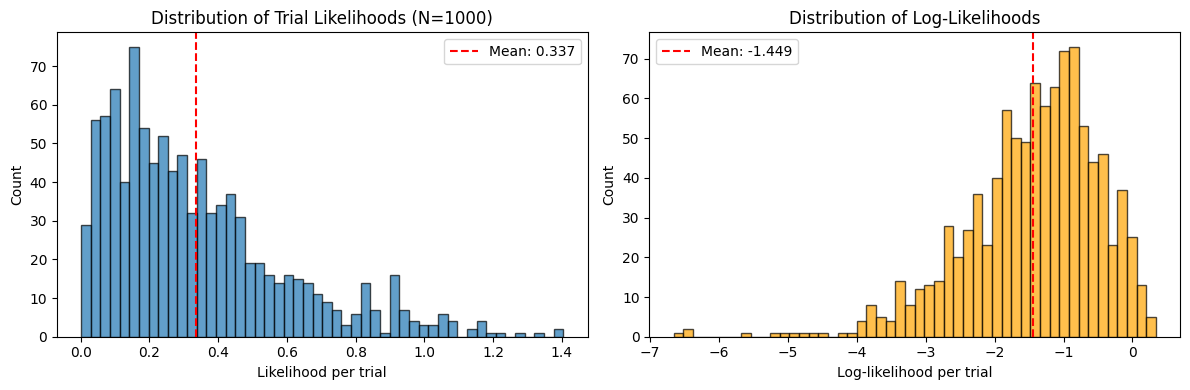

(Cython vs JAX verification shown later in the notebook)


In [13]:
# ============================================================
# DIAGNOSTIC: Verify likelihood computation across all trials
# ============================================================
# Check that likelihoods are reasonable and all trials are included

# Compute individual trial likelihoods using JAX
def get_trial_likelihoods(params):
    """Get likelihood for each trial (not log, not negated)."""
    eta, kappa, a, b, x0 = params
    mu_arrays = compute_mu_arrays(eta, kappa, jax_r1, jax_r2, jax_flag, jax_sacc_safe, jax_d, max_d)
    
    def single_trial(rt_i, choice_i, d_i, mu_i, sacc_safe_i):
        return get_addm_fptd_jax_fast(
            rt_i, d_i, mu_i, sacc_safe_i,
            TRUE_PARAMS['sigma'], a, b, x0, choice_i,
            trunc_num=TRUNC_NUM,
            safe_sacc=sacc_safe_i
        )
    
    return vmap(single_trial)(jax_rt, jax_choice, jax_d, mu_arrays, jax_sacc_safe)

# Get likelihoods at true params
true_params_list = [TRUE_PARAMS['eta'], TRUE_PARAMS['kappa'], TRUE_PARAMS['a'], TRUE_PARAMS['b'], TRUE_PARAMS['x0']]
trial_likelihoods = get_trial_likelihoods(true_params_list)

print("=" * 60)
print("LIKELIHOOD DIAGNOSTIC")
print("=" * 60)
print(f"Number of trials: {len(trial_likelihoods)}")
print(f"Likelihoods > 0: {jnp.sum(trial_likelihoods > 0)} / {len(trial_likelihoods)}")
print(f"Likelihoods = 0 or NaN: {jnp.sum(trial_likelihoods <= 0) + jnp.sum(jnp.isnan(trial_likelihoods))}")
print()
print(f"Likelihood statistics:")
print(f"  Min:    {float(jnp.min(trial_likelihoods)):.6f}")
print(f"  Max:    {float(jnp.max(trial_likelihoods)):.6f}")
print(f"  Mean:   {float(jnp.mean(trial_likelihoods)):.6f}")
print(f"  Median: {float(jnp.median(trial_likelihoods)):.6f}")
print()
print(f"Log-likelihood statistics:")
log_likes = jnp.log(jnp.maximum(trial_likelihoods, 1e-30))
print(f"  Mean log(L): {float(jnp.mean(log_likes)):.4f}")
print(f"  Sum log(L):  {float(jnp.sum(log_likes)):.4f}")
print(f"  Mean NLL:    {float(-jnp.mean(log_likes)):.4f}  (this is what we optimize)")
print(f"  Sum NLL:     {float(-jnp.sum(log_likes)):.4f}")
print()

# Quick visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of likelihoods
axes[0].hist(np.array(trial_likelihoods), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Likelihood per trial')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Distribution of Trial Likelihoods (N={NUM_TRIALS})')
axes[0].axvline(float(jnp.mean(trial_likelihoods)), color='red', linestyle='--', label=f'Mean: {float(jnp.mean(trial_likelihoods)):.3f}')
axes[0].legend()

# Histogram of log-likelihoods
axes[1].hist(np.array(log_likes), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Log-likelihood per trial')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Distribution of Log-Likelihoods')
axes[1].axvline(float(jnp.mean(log_likes)), color='red', linestyle='--', label=f'Mean: {float(jnp.mean(log_likes)):.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Note: Cython comparison will be shown later after cython_nll is defined
print("(Cython vs JAX verification shown later in the notebook)")


In [14]:
# Cython NLL wrapper (if available)
if CYTHON_AVAILABLE:
    def cython_nll(params):
        """Compute NLL using Cython implementation."""
        eta, kappa, a, b, x0 = params
        mu1 = kappa * (r1_data - eta * r2_data)
        mu2 = kappa * (eta * r1_data - r2_data)
        return compute_loss_parallel(
            mu1, mu2, rt_data, choice_data, flag_data,
            sacc_data_padded, d_data, max_d,
            TRUE_PARAMS['sigma'], a, b, x0
        )
    
    # Test
    test_cython_nll = cython_nll([0.7, 0.5, 2.1, 0.3, -0.2])
    print(f"Cython NLL at true params: {test_cython_nll:.4f}")


Cython NLL at true params: 1.4494


## 3. Likelihood Evaluation Timing


In [15]:
print("=" * 60)
print("LIKELIHOOD EVALUATION TIMING")
print("=" * 60)

n_evals = 20
results = {}

# Cython timing
if CYTHON_AVAILABLE:
    # Warmup
    _ = cython_nll([0.7, 0.5, 2.1, 0.3, -0.2])
    
    start = time.time()
    for _ in range(n_evals):
        _ = cython_nll([0.7, 0.5, 2.1, 0.3, -0.2])
    cython_time = (time.time() - start) / n_evals * 1000
    results['Cython'] = cython_time
    print(f"Cython (OpenMP):     {cython_time:.2f} ms/eval")

# JAX timing (no gradient) - uses fast version with pre-computed safe arrays
if RUN_JAX_NOGRAD:
    # Warmup / compile
    _ = jax_nll(test_params, jax_rt, jax_choice, jax_d, jax_r1, jax_r2, jax_flag, jax_sacc_safe, TRUE_PARAMS['sigma']).block_until_ready()
    
    start = time.time()
    for _ in range(n_evals):
        _ = jax_nll(test_params, jax_rt, jax_choice, jax_d, jax_r1, jax_r2, jax_flag, jax_sacc_safe, TRUE_PARAMS['sigma']).block_until_ready()
    jax_time = (time.time() - start) / n_evals * 1000
    results['JAX (fast)'] = jax_time
    print(f"JAX (fast+vmap):     {jax_time:.2f} ms/eval")

# JAX timing (with gradient)
if RUN_JAX_GRAD:
    # Warmup / compile
    _ = jax_nll_grad(test_params, jax_rt, jax_choice, jax_d, jax_r1, jax_r2, jax_flag, jax_sacc_safe, TRUE_PARAMS['sigma']).block_until_ready()
    
    start = time.time()
    for _ in range(n_evals):
        _ = jax_nll_grad(test_params, jax_rt, jax_choice, jax_d, jax_r1, jax_r2, jax_flag, jax_sacc_safe, TRUE_PARAMS['sigma']).block_until_ready()
    jax_grad_time = (time.time() - start) / n_evals * 1000
    results['JAX (fast)+grad'] = jax_grad_time
    print(f"JAX (fast+grad):     {jax_grad_time:.2f} ms/eval")

print()


LIKELIHOOD EVALUATION TIMING


Cython (OpenMP):     29.08 ms/eval
JAX (fast+vmap):     40.43 ms/eval
JAX (fast+grad):     216.76 ms/eval



## 4. Maximum Likelihood Estimation


In [16]:
# Parameter bounds
max_rt = np.max(rt_data)
bounds = Bounds(
    [0.01, 0.01, 0.5, 0.01, -2.0],   # lower bounds
    [0.99, 2.0,  4.0, 0.5,   2.0]    # upper bounds
)

# Initial guess (away from true values)
initial_guess = [0.5, 0.8, 1.5, 0.15, 0.0]

print(f"Initial guess: eta={initial_guess[0]}, kappa={initial_guess[1]}, a={initial_guess[2]}, b={initial_guess[3]}, x0={initial_guess[4]}")
print(f"True values:   eta={TRUE_PARAMS['eta']}, kappa={TRUE_PARAMS['kappa']}, a={TRUE_PARAMS['a']}, b={TRUE_PARAMS['b']}, x0={TRUE_PARAMS['x0']}")

optimization_results = {}


Initial guess: eta=0.5, kappa=0.8, a=1.5, b=0.15, x0=0.0
True values:   eta=0.7, kappa=0.5, a=2.1, b=0.3, x0=-0.2


### 4.1 Cython Optimization (Gradient-Free)


In [17]:
if CYTHON_AVAILABLE and RUN_CYTHON:
    print("=" * 60)
    print("CYTHON OPTIMIZATION (Nelder-Mead)")
    print("=" * 60)
    
    n_feval = [0]
    def cython_obj(params):
        n_feval[0] += 1
        return cython_nll(params)
    
    start = time.time()
    result_cython = minimize(
        cython_obj,
        x0=initial_guess,
        method='Nelder-Mead',
        options={'maxiter': 500, 'xatol': 1e-4, 'fatol': 1e-4}
    )
    cython_opt_time = time.time() - start
    
    optimization_results['Cython'] = {
        'time': cython_opt_time,
        'params': result_cython.x,
        'nll': result_cython.fun,
        'nfev': n_feval[0],
        'success': result_cython.success,
    }
    
    print(f"Time: {cython_opt_time:.1f}s")
    print(f"Function evaluations: {n_feval[0]}")
    print(f"Final NLL: {result_cython.fun:.4f}")
    print(f"Estimated parameters:")
    print(f"  eta:   {result_cython.x[0]:.4f} (true: {TRUE_PARAMS['eta']})")
    print(f"  kappa: {result_cython.x[1]:.4f} (true: {TRUE_PARAMS['kappa']})")
    print(f"  a:     {result_cython.x[2]:.4f} (true: {TRUE_PARAMS['a']})")
    print(f"  b:     {result_cython.x[3]:.4f} (true: {TRUE_PARAMS['b']})")
    print(f"  x0:    {result_cython.x[4]:.4f} (true: {TRUE_PARAMS['x0']})")


CYTHON OPTIMIZATION (Nelder-Mead)
Time: 5.3s
Function evaluations: 602
Final NLL: 1.4462
Estimated parameters:
  eta:   0.6787 (true: 0.7)
  kappa: 0.5204 (true: 0.5)
  a:     2.1953 (true: 2.1)
  b:     0.3296 (true: 0.3)
  x0:    -0.1859 (true: -0.2)


### 4.2 JAX Optimization (Gradient-Free)


In [18]:
if RUN_JAX_NOGRAD:
    print("=" * 60)
    print("JAX OPTIMIZATION (Nelder-Mead with restarts, no gradients)")
    print("=" * 60)
    
    # Use multiple random restarts to avoid getting stuck
    # (Nelder-Mead can get stuck near initial guess, especially for x0)
    N_RESTARTS = 3
    rng_opt = np.random.default_rng(123)
    
    def jax_obj_nograd(params):
        params_jax = jnp.array(params)
        return float(jax_nll(params_jax, jax_rt, jax_choice, jax_d, jax_r1, jax_r2, jax_flag, jax_sacc_safe, TRUE_PARAMS['sigma']))
    
    best_result = None
    best_nll = np.inf
    total_feval = 0
    
    start = time.time()
    
    for restart in range(N_RESTARTS):
        # Generate random initial guess within bounds
        if restart == 0:
            x0_restart = initial_guess  # First try: use default initial guess
        else:
            # Random restart: sample uniformly within bounds
            x0_restart = [
                rng_opt.uniform(0.3, 0.9),    # eta
                rng_opt.uniform(0.2, 1.0),    # kappa
                rng_opt.uniform(1.0, 3.0),    # a
                rng_opt.uniform(0.1, 0.4),    # b
                rng_opt.uniform(-1.0, 1.0),   # x0 - wider range!
            ]
        
        result = minimize(
            jax_obj_nograd,
            x0=x0_restart,
            method='Nelder-Mead',
            options={'maxiter': 500, 'xatol': 1e-5, 'fatol': 1e-5}
        )
        total_feval += result.nfev
        
        if result.fun < best_nll:
            best_nll = result.fun
            best_result = result
            print(f"  Restart {restart+1}: NLL={result.fun:.4f} (new best!)")
        else:
            print(f"  Restart {restart+1}: NLL={result.fun:.4f}")
    
    jax_nograd_opt_time = time.time() - start
    result_jax_nograd = best_result
    
    optimization_results['JAX fast (no grad)'] = {
        'time': jax_nograd_opt_time / N_RESTARTS,
        'params': result_jax_nograd.x,
        'nll': result_jax_nograd.fun,
        'nfev': total_feval,
        'n_restarts': N_RESTARTS,
        'success': result_jax_nograd.success,
    }
    
    print(f"\nBest result from {N_RESTARTS} restarts:")
    print(f"Time: {jax_nograd_opt_time:.1f}s")
    print(f"Total function evaluations: {total_feval}")
    print(f"Final NLL: {result_jax_nograd.fun:.4f}")
    print(f"Estimated parameters:")
    print(f"  eta:   {result_jax_nograd.x[0]:.4f} (true: {TRUE_PARAMS['eta']})")
    print(f"  kappa: {result_jax_nograd.x[1]:.4f} (true: {TRUE_PARAMS['kappa']})")
    print(f"  a:     {result_jax_nograd.x[2]:.4f} (true: {TRUE_PARAMS['a']})")
    print(f"  b:     {result_jax_nograd.x[3]:.4f} (true: {TRUE_PARAMS['b']})")
    print(f"  x0:    {result_jax_nograd.x[4]:.4f} (true: {TRUE_PARAMS['x0']})")


JAX OPTIMIZATION (Nelder-Mead with restarts, no gradients)
  Restart 1: NLL=1.4637 (new best!)
  Restart 2: NLL=1.4462 (new best!)
  Restart 3: NLL=1.4462

Best result from 3 restarts:
Time: 32.4s
Total function evaluations: 996
Final NLL: 1.4462
Estimated parameters:
  eta:   0.6786 (true: 0.7)
  kappa: 0.5206 (true: 0.5)
  a:     2.1955 (true: 2.1)
  b:     0.3297 (true: 0.3)
  x0:    -0.1858 (true: -0.2)


### 4.3 JAX Optimization (With Gradients - L-BFGS-B)


In [19]:
if RUN_JAX_GRAD:
    print("=" * 60)
    print("JAX OPTIMIZATION (L-BFGS-B with gradients, fast version)")
    print("=" * 60)
    
    n_feval = [0]
    n_geval = [0]
    
    def jax_obj_with_grad(params):
        n_feval[0] += 1
        params_jax = jnp.array(params)
        return float(jax_nll(params_jax, jax_rt, jax_choice, jax_d, jax_r1, jax_r2, jax_flag, jax_sacc_safe, TRUE_PARAMS['sigma']))
    
    def jax_gradient(params):
        n_geval[0] += 1
        params_jax = jnp.array(params)
        g = jax_nll_grad(params_jax, jax_rt, jax_choice, jax_d, jax_r1, jax_r2, jax_flag, jax_sacc_safe, TRUE_PARAMS['sigma'])
        return np.array(g)
    
    start = time.time()
    result_jax_grad = minimize(
        jax_obj_with_grad,
        x0=initial_guess,
        method='L-BFGS-B',
        jac=jax_gradient,
        bounds=bounds,
        options={'maxiter': 500, 'gtol': 1e-5}
    )
    jax_grad_opt_time = time.time() - start
    
    optimization_results['JAX fast (L-BFGS-B)'] = {
        'time': jax_grad_opt_time,
        'params': result_jax_grad.x,
        'nll': result_jax_grad.fun,
        'nfev': n_feval[0],
        'ngev': n_geval[0],
        'success': result_jax_grad.success,
    }
    
    print(f"Time: {jax_grad_opt_time:.1f}s")
    print(f"Function evaluations: {n_feval[0]}")
    print(f"Gradient evaluations: {n_geval[0]}")
    print(f"Final NLL: {result_jax_grad.fun:.4f}")
    print(f"Estimated parameters:")
    print(f"  eta:   {result_jax_grad.x[0]:.4f} (true: {TRUE_PARAMS['eta']})")
    print(f"  kappa: {result_jax_grad.x[1]:.4f} (true: {TRUE_PARAMS['kappa']})")
    print(f"  a:     {result_jax_grad.x[2]:.4f} (true: {TRUE_PARAMS['a']})")
    print(f"  b:     {result_jax_grad.x[3]:.4f} (true: {TRUE_PARAMS['b']})")
    print(f"  x0:    {result_jax_grad.x[4]:.4f} (true: {TRUE_PARAMS['x0']})")


JAX OPTIMIZATION (L-BFGS-B with gradients, fast version)
Time: 6.9s
Function evaluations: 31
Gradient evaluations: 31
Final NLL: 1.4462
Estimated parameters:
  eta:   0.6787 (true: 0.7)
  kappa: 0.5203 (true: 0.5)
  a:     2.1953 (true: 2.1)
  b:     0.3296 (true: 0.3)
  x0:    -0.1860 (true: -0.2)


## 5. Results Summary


In [20]:
print("=" * 70)
print("OPTIMIZATION RESULTS SUMMARY")
print("=" * 70)
print()

print(f"{'Method':<20} {'Time (s)':<12} {'NLL':<12} {'f evals':<10} {'g evals':<10}")
print("-" * 70)

for name, res in optimization_results.items():
    ngev = res.get('ngev', '-')
    print(f"{name:<20} {res['time']:<12.1f} {res['nll']:<12.4f} {res['nfev']:<10} {ngev:<10}")

print()
print("Parameter Estimates:")
print(f"{'Method':<20} {'eta':<10} {'kappa':<10} {'a':<10} {'b':<10} {'x0':<10}")
print("-" * 70)
print(f"{'TRUE':<20} {TRUE_PARAMS['eta']:<10.4f} {TRUE_PARAMS['kappa']:<10.4f} {TRUE_PARAMS['a']:<10.4f} {TRUE_PARAMS['b']:<10.4f} {TRUE_PARAMS['x0']:<10.4f}")

for name, res in optimization_results.items():
    p = res['params']
    print(f"{name:<20} {p[0]:<10.4f} {p[1]:<10.4f} {p[2]:<10.4f} {p[3]:<10.4f} {p[4]:<10.4f}")


OPTIMIZATION RESULTS SUMMARY

Method               Time (s)     NLL          f evals    g evals   
----------------------------------------------------------------------
Cython               5.3          1.4462       602        -         
JAX fast (no grad)   10.8         1.4462       996        -         
JAX fast (L-BFGS-B)  6.9          1.4462       31         31        

Parameter Estimates:
Method               eta        kappa      a          b          x0        
----------------------------------------------------------------------
TRUE                 0.7000     0.5000     2.1000     0.3000     -0.2000   
Cython               0.6787     0.5204     2.1953     0.3296     -0.1859   
JAX fast (no grad)   0.6786     0.5206     2.1955     0.3297     -0.1858   
JAX fast (L-BFGS-B)  0.6787     0.5203     2.1953     0.3296     -0.1860   


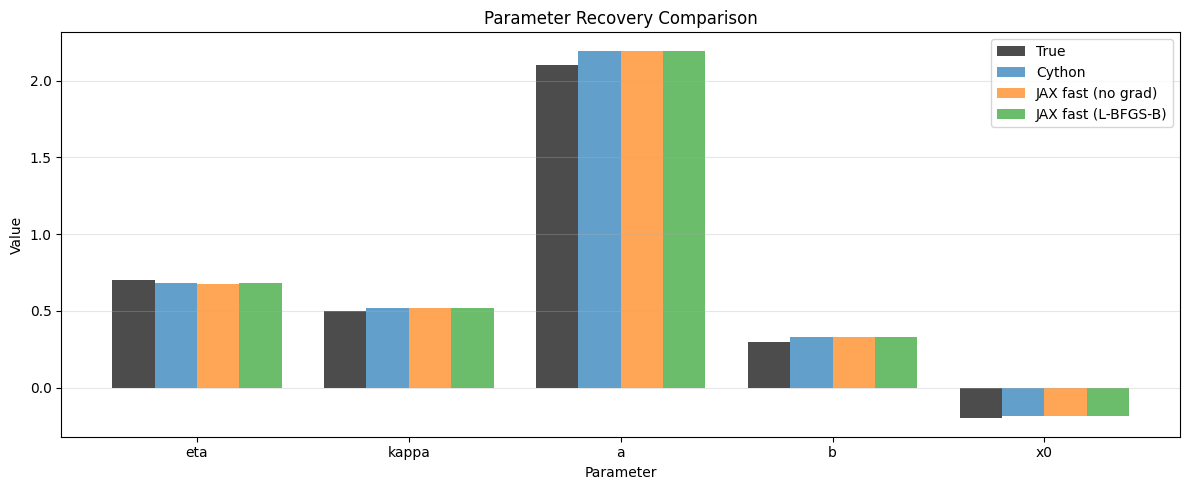

In [21]:
# Visualize parameter recovery
param_names = ['eta', 'kappa', 'a', 'b', 'x0']
true_values = [TRUE_PARAMS[p] for p in param_names]

fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(len(param_names))
width = 0.2

# Plot true values
ax.bar(x - width * 1.5, true_values, width, label='True', color='black', alpha=0.7)

# Plot estimated values
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, (name, res) in enumerate(optimization_results.items()):
    ax.bar(x - width * 0.5 + i * width, res['params'], width, label=name, color=colors[i % len(colors)], alpha=0.7)

ax.set_xlabel('Parameter')
ax.set_ylabel('Value')
ax.set_title('Parameter Recovery Comparison')
ax.set_xticks(x)
ax.set_xticklabels(param_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


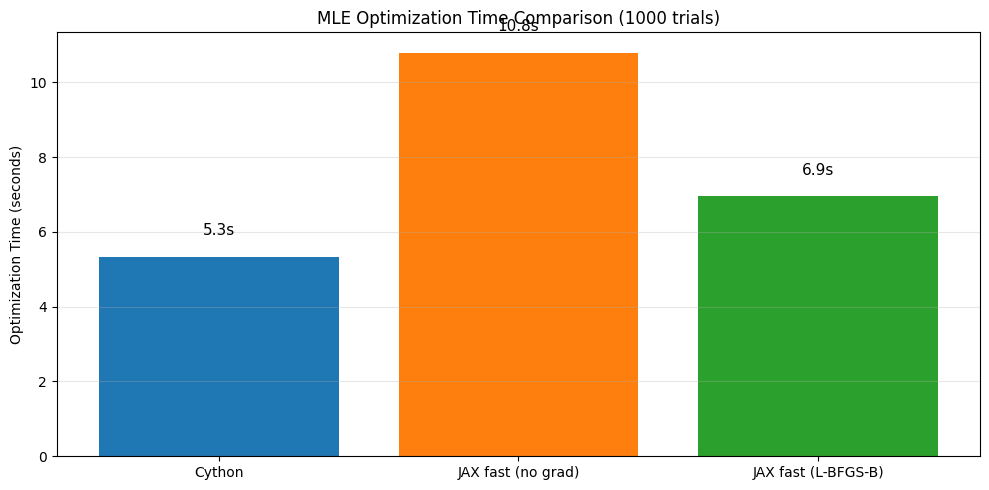

In [22]:
# Timing comparison bar chart
if len(optimization_results) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    names = list(optimization_results.keys())
    times = [optimization_results[n]['time'] for n in names]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    bars = ax.bar(names, times, color=colors[:len(names)])
    
    ax.set_ylabel('Optimization Time (seconds)')
    ax.set_title(f'MLE Optimization Time Comparison ({NUM_TRIALS} trials)')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add time labels on bars
    for bar, t in zip(bars, times):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{t:.1f}s', ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    plt.show()


## 5.1 Likelihood Landscape Analysis

Understanding parameter identifiability by examining the likelihood profile around the optimum. 

**Interpretation:**
- **High curvature** = Well-identified parameter (small changes in parameter → large changes in NLL)
- **Low curvature** = Poorly identified / flat landscape (harder to optimize)
- **Green line** = Estimated value
- **Red line** = True value


In [23]:
optimization_results

{'Cython': {'time': 5.335551023483276,
  'params': array([ 0.67870015,  0.52036384,  2.19533443,  0.32957821, -0.18594826]),
  'nll': np.float64(1.4461661339000271),
  'nfev': 602,
  'success': True},
 'JAX fast (no grad)': {'time': 10.798119386037191,
  'params': array([ 0.67859572,  0.5205592 ,  2.19550521,  0.32969677, -0.1857737 ]),
  'nll': np.float64(1.446165919303894),
  'nfev': 996,
  'n_restarts': 3,
  'success': True},
 'JAX fast (L-BFGS-B)': {'time': 6.949890851974487,
  'params': array([ 0.67868349,  0.52033444,  2.19529814,  0.32957802, -0.185966  ]),
  'nll': 1.446165919303894,
  'nfev': 31,
  'ngev': 31,
  'success': True}}

Analyzing likelihood landscape around JAX fast (no grad) optimum...
Best NLL: 1.4462



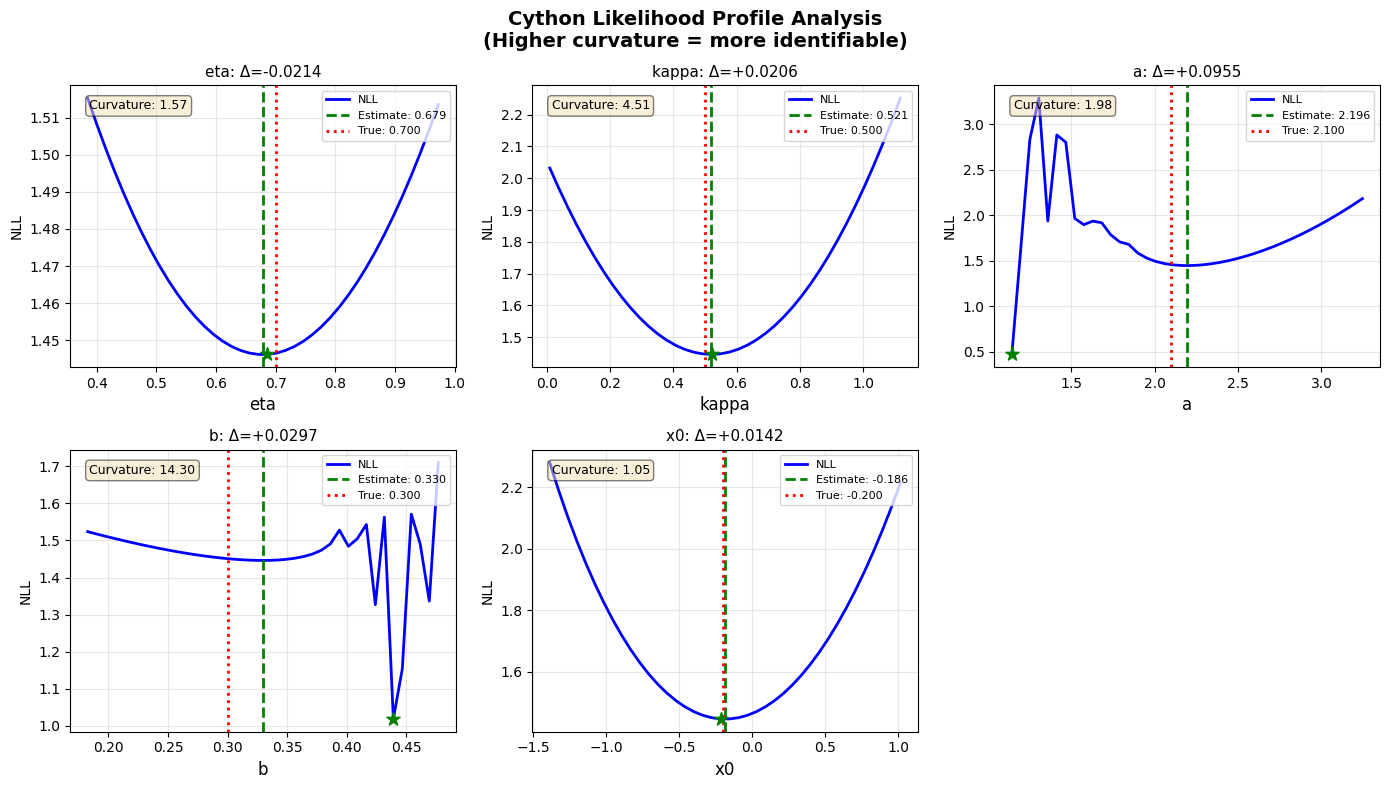

In [24]:
# ============================================================
# LIKELIHOOD LANDSCAPE ANALYSIS
# ============================================================
# Plot profile likelihoods to understand parameter sensitivity

def plot_likelihood_profiles(best_params, param_names, true_params, nll_func, 
                             bounds, n_points=50, title_prefix=""):
    """
    Plot 1D likelihood profiles for each parameter.
    
    For each parameter, varies it while holding others fixed at the optimum,
    showing how sensitive the likelihood is to that parameter.
    """
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    axes = axes.flatten()
    
    for i, (name, ax) in enumerate(zip(param_names, axes)):
        if i >= len(param_names):
            ax.set_visible(False)
            continue
            
        # Create parameter grid around the optimum
        opt_val = best_params[i]
        true_val = true_params[name]
        
        # Use bounds if available, otherwise ±50% around optimum
        if bounds is not None:
            lo, hi = bounds.lb[i], bounds.ub[i]
            # Focus on region around optimum
            margin = (hi - lo) * 0.3
            lo = max(lo, opt_val - margin)
            hi = min(hi, opt_val + margin)
        else:
            margin = abs(opt_val) * 0.5 + 0.1
            lo, hi = opt_val - margin, opt_val + margin
        
        param_grid = np.linspace(lo, hi, n_points)
        nll_values = []
        
        for val in param_grid:
            test_params = best_params.copy()
            test_params[i] = val
            nll_values.append(nll_func(test_params))
        
        nll_values = np.array(nll_values)
        
        # Plot
        ax.plot(param_grid, nll_values, 'b-', linewidth=2, label='NLL')
        ax.axvline(opt_val, color='green', linestyle='--', linewidth=2, 
                   label=f'Estimate: {opt_val:.3f}')
        ax.axvline(true_val, color='red', linestyle=':', linewidth=2, 
                   label=f'True: {true_val:.3f}')
        
        # Mark the minimum
        min_idx = np.argmin(nll_values)
        ax.scatter([param_grid[min_idx]], [nll_values[min_idx]], 
                   color='green', s=100, zorder=5, marker='*')
        
        ax.set_xlabel(name, fontsize=12)
        ax.set_ylabel('NLL', fontsize=10)
        ax.set_title(f'{name}: Δ={opt_val - true_val:+.4f}', fontsize=11)
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3)
        
        # Add curvature info (higher = more sensitive)
        if len(nll_values) > 2:
            # Estimate curvature at optimum using finite differences
            idx_opt = np.argmin(np.abs(param_grid - opt_val))
            if 0 < idx_opt < len(nll_values) - 1:
                h = param_grid[1] - param_grid[0]
                curvature = (nll_values[idx_opt+1] - 2*nll_values[idx_opt] + nll_values[idx_opt-1]) / h**2
                ax.text(0.05, 0.95, f'Curvature: {curvature:.2f}', 
                        transform=ax.transAxes, fontsize=9, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide extra subplot
    if len(param_names) < 6:
        axes[5].set_visible(False)
    
    fig.suptitle(f'{title_prefix}Likelihood Profile Analysis\n(Higher curvature = more identifiable)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

METHOD = "JAX fast (no grad)"

# Use the best result (Cython or JAX L-BFGS-B)
if METHOD == 'Cython':
    best_result = optimization_results['Cython']
    best_method = 'Cython'
elif METHOD == 'JAX fast (L-BFGS-B)':
    best_result = optimization_results['JAX fast (L-BFGS-B)']
    best_method = 'JAX (L-BFGS-B)'
elif METHOD == 'JAX fast (no grad)':
    best_result = optimization_results['JAX fast (no grad)']
    best_method = 'JAX fast (no grad)'

print(f"Analyzing likelihood landscape around {best_method} optimum...")
print(f"Best NLL: {best_result['nll']:.4f}")
print()

# Define NLL function for profiling (use Cython if available, else JAX)
if CYTHON_AVAILABLE:
    profile_nll = cython_nll
    profile_label = "Cython"
else:
    def profile_nll(params):
        params_jax = jnp.array(params)
        return float(jax_nll(params_jax, jax_rt, jax_choice, jax_d, jax_r1, jax_r2, jax_flag, jax_sacc_safe, TRUE_PARAMS['sigma']))
    profile_label = "JAX"

param_names = ['eta', 'kappa', 'a', 'b', 'x0']
true_params_dict = {name: TRUE_PARAMS[name] for name in param_names}

_ = plot_likelihood_profiles(
    best_params=best_result['params'],
    param_names=param_names,
    true_params=true_params_dict,
    nll_func=profile_nll,
    bounds=bounds,
    n_points=40,
    title_prefix=f"{profile_label} "
)


## 6. Key Takeaways

### Performance
- **Gradient-based optimization (L-BFGS-B)** typically converges faster than gradient-free methods (Nelder-Mead) in terms of wall time
- **JAX with gradients** requires fewer function evaluations due to gradient information
- **Cython + OpenMP** is competitive for gradient-free optimization due to parallel likelihood evaluation

### Accuracy
- All methods should recover parameters close to true values with sufficient data
- Gradient-based methods may find better optima due to more accurate convergence

### When to Use What
| Scenario | Recommendation |
|----------|----------------|
| Large datasets (>10k trials) | JAX (especially on GPU) |
| Need gradients for Bayesian inference | JAX only |
| Simple MLE, no GPU | Cython + OpenMP |
| Prototyping | JAX (cleaner, more flexible) |

### GPU Considerations
On a GPU machine, JAX would show even larger speedups:
- Small batches (<100): Overhead-dominated, similar to CPU
- Large batches (>10k): 10-100x speedup over CPU
- The `trunc_num=6` threshold we use is optimized for CPU; GPU may prefer higher values
